
#### Copyright 2020 Connaissance Publishing.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# **Understanding Deep Learning: Application in Rare Event Prediction**

Author: Chitta Ranjan, Ph.D.

[ProcessMiner, Inc.](https://processminer.com)

cranjan@processminer.com

LinkedIn: https://www.linkedin.com/in/chitta-ranjan-b0851911/

Medium: https://medium.com/@cran2367

# Convolutional Neural Network (CNN) for Rare Event Prediction

# Connection

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
root_path = 'gdrive/My Drive/understanding-deep-learning/codebase'
import os
os.chdir(root_path)
os.getcwd()

# Import Libraries

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Flatten
from tensorflow.python.keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

# user-defined libraries
import utilities.datapreprocessing as dp
import utilities.performancemetrics as pm
import utilities.simpleplots as sp

from numpy.random import seed
seed(1)

SEED = 123  # used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
plt.rcParams.update({'font.size': 22})

# Data Preparation

The data is taken from https://arxiv.org/abs/1809.10717.

In [ ]:
'''Download data here:
https://docs.google.com/forms/d/e/1FAIpQLSdyUk3lfDl7I5KYK_pw285LCApc-_RcoC0Tf9cnDnZ_TWzPAw/viewform
'''
df = pd.read_csv("data/processminer-sheet-break-rare-event-dataset.csv")
df.head(n=5)  # visualize the data.

# Hot encoding
hotencoding1 = pd.get_dummies(df['Grade&Bwt'])
hotencoding1 = hotencoding1.add_prefix('grade_')
hotencoding2 = pd.get_dummies(df['EventPress'])
hotencoding2 = hotencoding2.add_prefix('eventpress_')

df = df.drop(['Grade&Bwt', 'EventPress'], axis=1)

df = pd.concat([df, hotencoding1, hotencoding2], axis=1)

# Rename response column name for ease of understanding
df = df.rename(columns={'SheetBreak': 'y'})  

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = dp.curve_shift(df, shift_by=-2)

# Sort by time and drop the time column.
df['DateTime'] = pd.to_datetime(df.DateTime)
df = df.sort_values(by='DateTime')
df = df.drop(['DateTime'], axis=1)

# Converts df to numpy array
input_X = df.loc[:, df.columns != 'y'].values  
input_y = df['y'].values

# Multivariate Time Series Modeling

## Baseline Model

In [ ]:
# Data Temporalize
lookback = 20
X, y = dp.temporalize(X=input_X, y=input_y, lookback=lookback)

# Divide the data into train, valid, and test
X_train, X_test, y_train, y_test = train_test_split(np.array(X),
                                                    np.array(y),
                                                    test_size=DATA_SPLIT_PCT,
                                                    random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      y_train,
                                                      test_size=DATA_SPLIT_PCT,
                                                      random_state=SEED)

# Scaler using the training data.
scaler = StandardScaler().fit(dp.flatten(X_train))

X_train_scaled = dp.scale(X_train, scaler)
X_valid_scaled = dp.scale(X_valid, scaler)
X_test_scaled = dp.scale(X_test, scaler)

# Axes lengths
TIMESTEPS = X_train_scaled.shape[1]
N_FEATURES = X_train_scaled.shape[2]

In [ ]:
model = Sequential()
model.add(Input(shape=(TIMESTEPS, 
                       N_FEATURES), 
                name='input'))
model.add(Conv1D(filters=16, 
                 kernel_size=4,
                 activation='relu', 
                 padding='valid'))
model.add(MaxPool1D(pool_size=4, 
                    padding='valid'))
model.add(Flatten())
model.add(Dense(units=16, 
                activation='relu'))
model.add(Dense(units=1, 
                activation='sigmoid', 
                name='output'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 17, 16)            4432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 5,489
Trainable params: 5,489
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  pm.F1Score(),
                  pm.FalsePositiveRate()
              ])
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=150,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=0).history

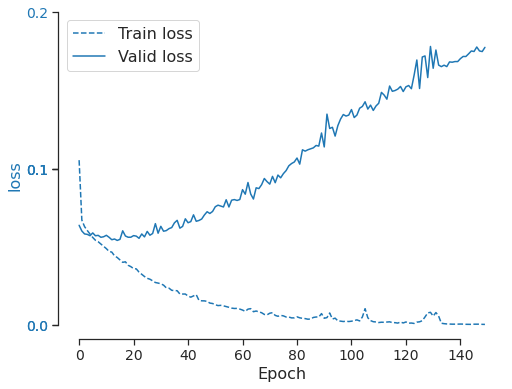

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
fig.savefig('cnn_baseline_loss.pdf', bbox_inches='tight')

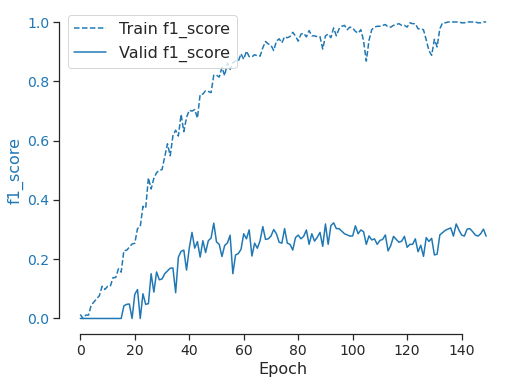

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('cnn_baseline_f1_score.pdf', bbox_inches='tight')

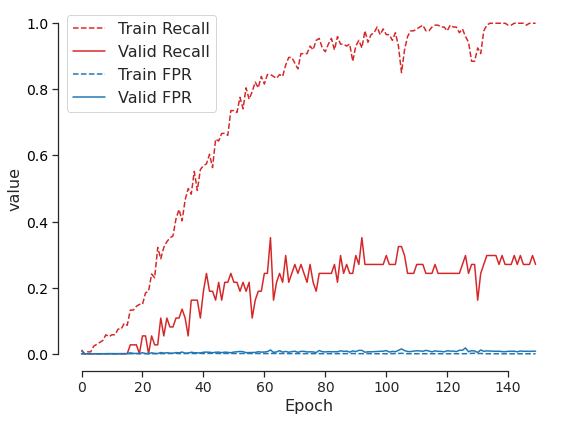

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
fig.savefig('cnn_baseline_recall_fpr.pdf', bbox_inches='tight')

## Learn Longer-term Dependencies

In [ ]:
# Data Temporalize
lookback = 240
X, y = dp.temporalize(X=input_X, 
                      y=input_y, 
                      lookback=lookback)
X_train, X_test, y_train, y_test = 
  train_test_split(np.array(X),
                   np.array(y),
                   test_size=DATA_SPLIT_PCT,
                   random_state=SEED)
X_train, X_valid, y_train, y_valid = 
  train_test_split(X_train,
                   y_train,
                   test_size=DATA_SPLIT_PCT,
                   random_state=SEED)
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(dp.flatten(X_train))

X_train_scaled = dp.scale(X_train, scaler)
X_valid_scaled = dp.scale(X_valid, scaler)
X_test_scaled = dp.scale(X_test, scaler)

TIMESTEPS = X_train_scaled.shape[1]
N_FEATURES = X_train_scaled.shape[2]

In [ ]:
model = Sequential()
model.add(Input(shape=(TIMESTEPS, 
                       N_FEATURES), 
                name='input'))
model.add(Conv1D(filters=16, 
                 kernel_size=4, 
                 activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPool1D(pool_size=4))
model.add(Flatten())
model.add(Dense(units=16, 
                activation='relu'))
model.add(Dense(units=1, 
                activation='sigmoid', 
                name='output'))
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  pm.F1Score(),
                  pm.FalsePositiveRate()
              ])
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=150,
                    validation_data=(X_valid_scaled, 
                                     y_valid),
                    verbose=0).history

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 237, 16)           4432      
_________________________________________________________________
dropout_9 (Dropout)          (None, 237, 16)           0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 59, 16)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 944)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                15120     
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 19,569
Trainable params: 19,569
Non-trainable params: 0
__________________________________________________

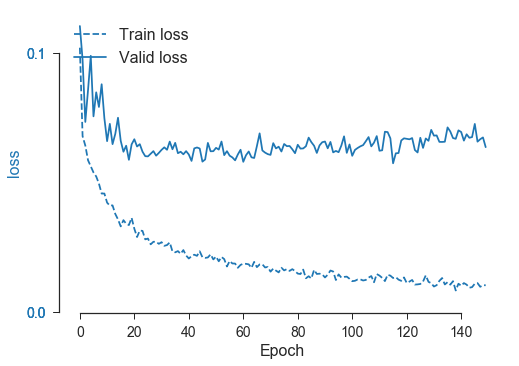

In [ ]:
plt, fig = simpleplots.plot_metric(history, metric='loss')
fig.savefig('cnn_baseline_1d_lookback240_dropout_loss.pdf', bbox_inches='tight')

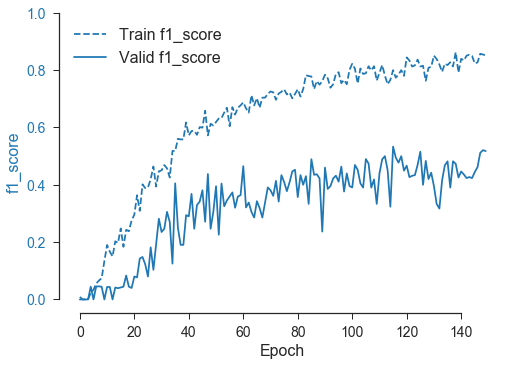

In [ ]:
plt, fig = simpleplots.plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('cnn_baseline_1d_lookback240_dropout_f1_score.pdf', bbox_inches='tight')

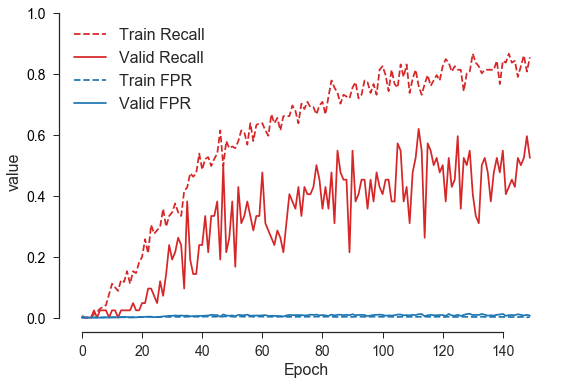

In [ ]:
plt, fig = simpleplots.plot_model_recall_fpr(history)
fig.savefig('cnn_baseline_1d_lookback240_dropout_recall_fpr.pdf', bbox_inches='tight')

## Multivariate Time Series Modeled as Image


### Conv1D and Conv2D Equivalence


In [ ]:
# Data Temporalize
lookback = 20
X, y = dp.temporalize(X=input_X, 
                      y=input_y, 
                      lookback=lookback)
X_train, X_test, y_train, y_test = train_test_split(np.array(X),
                   np.array(y),
                   test_size=DATA_SPLIT_PCT,
                   random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                   y_train,
                   test_size=DATA_SPLIT_PCT,
                   random_state=SEED)
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(dp.flatten(X_train))

X_train_scaled = dp.scale(X_train, scaler)
X_valid_scaled = dp.scale(X_valid, scaler)
X_test_scaled = dp.scale(X_test, scaler)

TIMESTEPS = X_train_scaled.shape[1]
N_FEATURES = X_train_scaled.shape[2]

In [ ]:
def reshape4d(X): 
  return X.reshape((X.shape[0], 
                    X.shape[1], 
                    X.shape[2], 
                    1))

model = Sequential()
model.add(Input(shape=(TIMESTEPS, 
                       N_FEATURES, 
                       1), 
                name='input'))
model.add(Conv2D(filters=16, 
                 kernel_size=(4, N_FEATURES),
                 activation='relu', 
                 data_format='channels_last'))
model.add(MaxPool2D(pool_size=(4, 1)))
model.add(Flatten())
model.add(Dense(units=16, 
                activation='relu'))
model.add(Dense(units=1, 
                activation='sigmoid', 
                name='output'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 17, 1, 16)         4432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 1, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 5,489
Trainable params: 5,489
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  pm.F1Score(),
                  pm.FalsePositiveRate()
              ])
history = model.fit(x=reshape4d(X_train_scaled),
                    y=y_train,
                    batch_size=128,
                    epochs=150,
                    validation_data=
                      (reshape4d(X_valid_scaled), 
                       y_valid),
                    verbose=0).history

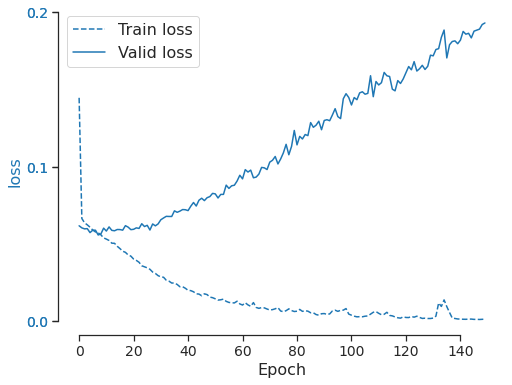

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
fig.savefig('cnn_baseline_2d_image_allcrosssection_loss.pdf', bbox_inches='tight')

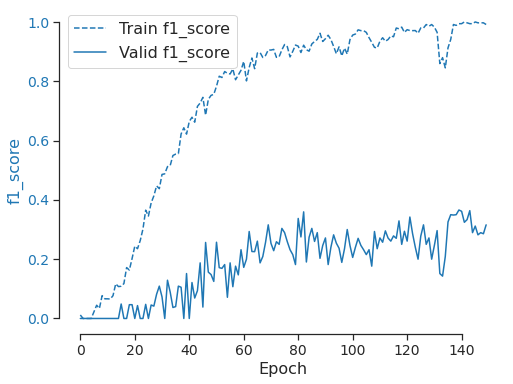

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('cnn_baseline_2d_image_allcrosssection_f1_score.pdf', bbox_inches='tight')

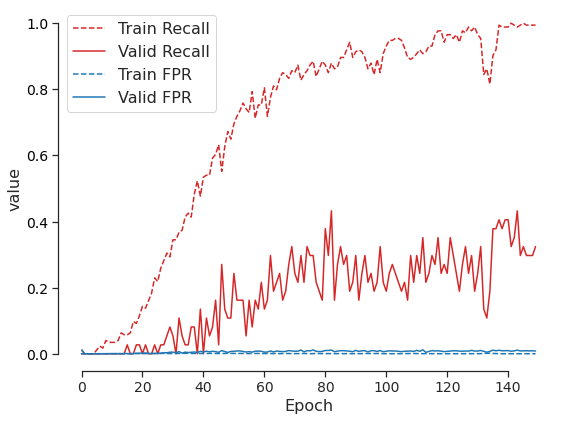

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
fig.savefig('cnn_baseline_2d_image_allcrosssection_recall_fpr.pdf', bbox_inches='tight')

### Neighborhood Model

In [ ]:
def reshape4d(X): 
  return X.reshape((X.shape[0], 
                    X.shape[1], 
                    X.shape[2], 
                    1))

model = Sequential()
model.add(Input(shape=(TIMESTEPS, 
                       N_FEATURES, 
                       1), 
                name='input'))
model.add(Conv2D(filters=16, 
                 kernel_size=(4, 4),
                 activation='relu', 
                 data_format='channels_last', 
                 name='Conv2d'))
model.add(MaxPool2D(pool_size=(4, 4), 
                    name='MaxPool'))
model.add(Flatten(name='Flatten'))
model.add(Dense(units=16, 
                activation='relu', 
                name='Dense'))
model.add(Dense(units=1, 
                activation='sigmoid', 
                name='output'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2d (Conv2D)              (None, 17, 66, 16)        272       
_________________________________________________________________
MaxPool (MaxPooling2D)       (None, 4, 16, 16)         0         
_________________________________________________________________
Flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
Dense (Dense)                (None, 16)                16400     
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 16,689
Trainable params: 16,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  pm.F1Score(),
                  pm.FalsePositiveRate()
              ])
history = model.fit(x=reshape4d(X_train_scaled),
                    y=y_train,
                    batch_size=128,
                    epochs=150,
                    validation_data=(reshape4d(X_valid_scaled), 
                                     y_valid),
                    verbose=0).history

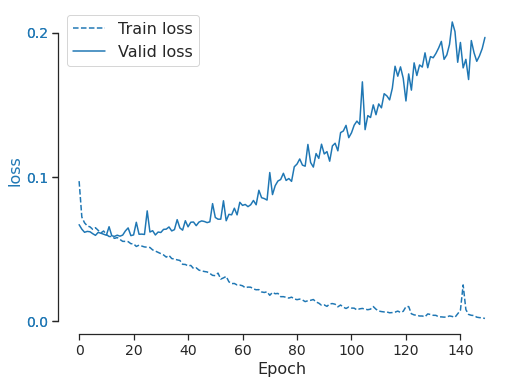

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
fig.savefig('cnn_baseline_2d_image_neighborsonly_loss.pdf', bbox_inches='tight')

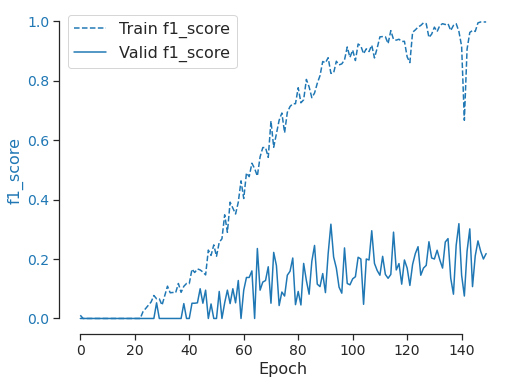

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('cnn_baseline_2d_image_neighborsonly_f1_score.pdf', bbox_inches='tight')

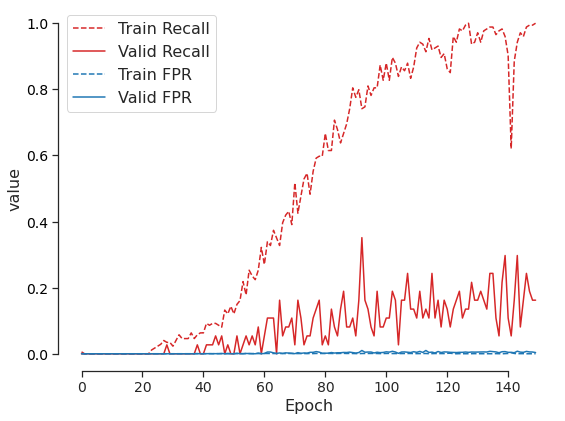

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
fig.savefig('cnn_baseline_2d_image_neighborsonly_recall_fpr.pdf', bbox_inches='tight')

## 1x1 Convolution

In [ ]:
model = Sequential()
model.add(Input(shape=(TIMESTEPS, 
                       N_FEATURES), 
                name='input'))
model.add(Conv1D(filters=64, 
                 kernel_size=4, 
                 activation='relu', 
                 name='Convlayer'))
model.add(Dropout(rate=0.5, 
                  name='dropout'))
model.add(Conv1D(filters=32, 
                 kernel_size=1, 
                 activation='relu', 
                 name='Conv1x1'))
model.add(MaxPool1D(pool_size=4, 
                    name='maxpooling'))
model.add(Flatten(name='flatten'))
model.add(Dense(units=16, 
                activation='relu', 
                name='dense'))
model.add(Dense(units=1, 
                activation='sigmoid', 
                name='output'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convlayer (Conv1D)           (None, 237, 64)           17728     
_________________________________________________________________
dropout (Dropout)            (None, 237, 64)           0         
_________________________________________________________________
Conv1x1 (Conv1D)             (None, 237, 32)           2080      
_________________________________________________________________
maxpooling (MaxPooling1D)    (None, 59, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1888)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                30224     
_________________________________________________________________
output (Dense)               (None, 1)                 1

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  pm.F1Score(),
                  pm.FalsePositiveRate()
              ])
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=150,
                    validation_data=(X_valid_scaled, 
                                     y_valid),
                    verbose=0).history

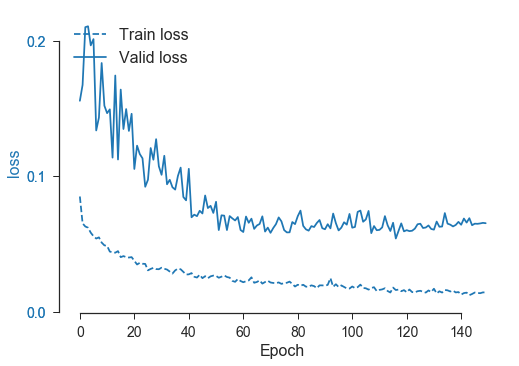

In [ ]:
plt, fig = simpleplots.plot_metric(history, metric='loss')
fig.savefig('cnn_baseline_1d_lookback240_1x1_loss.pdf', bbox_inches='tight')

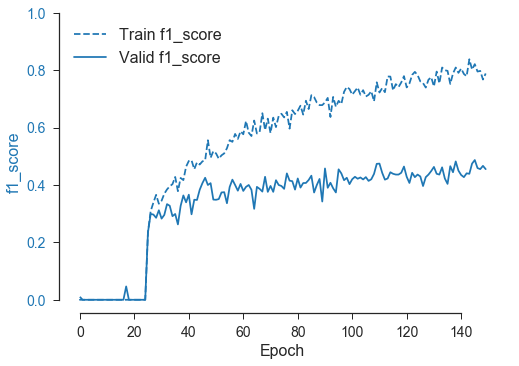

In [ ]:
plt, fig = simpleplots.plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('cnn_baseline_1d_lookback240_1x1_f1_score.pdf', bbox_inches='tight')

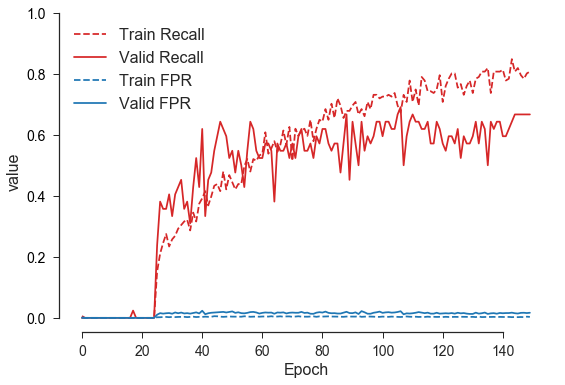

In [ ]:
plt, fig = simpleplots.plot_model_recall_fpr(history)
fig.savefig('cnn_baseline_1d_lookback240_1x1_recall_fpr.pdf', bbox_inches='tight')

## Visualization for Interpretation

###  Filters Visualization

In [ ]:
# The model layers
model.layers

In [ ]:
# retrieve weights from the first convolutional layer
filters, biases = model.get_layer('Convlayer').get_weights()
print(model.get_layer('Convlayer').name, filters.shape)

Convlayer (4, 69, 64)


In [ ]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

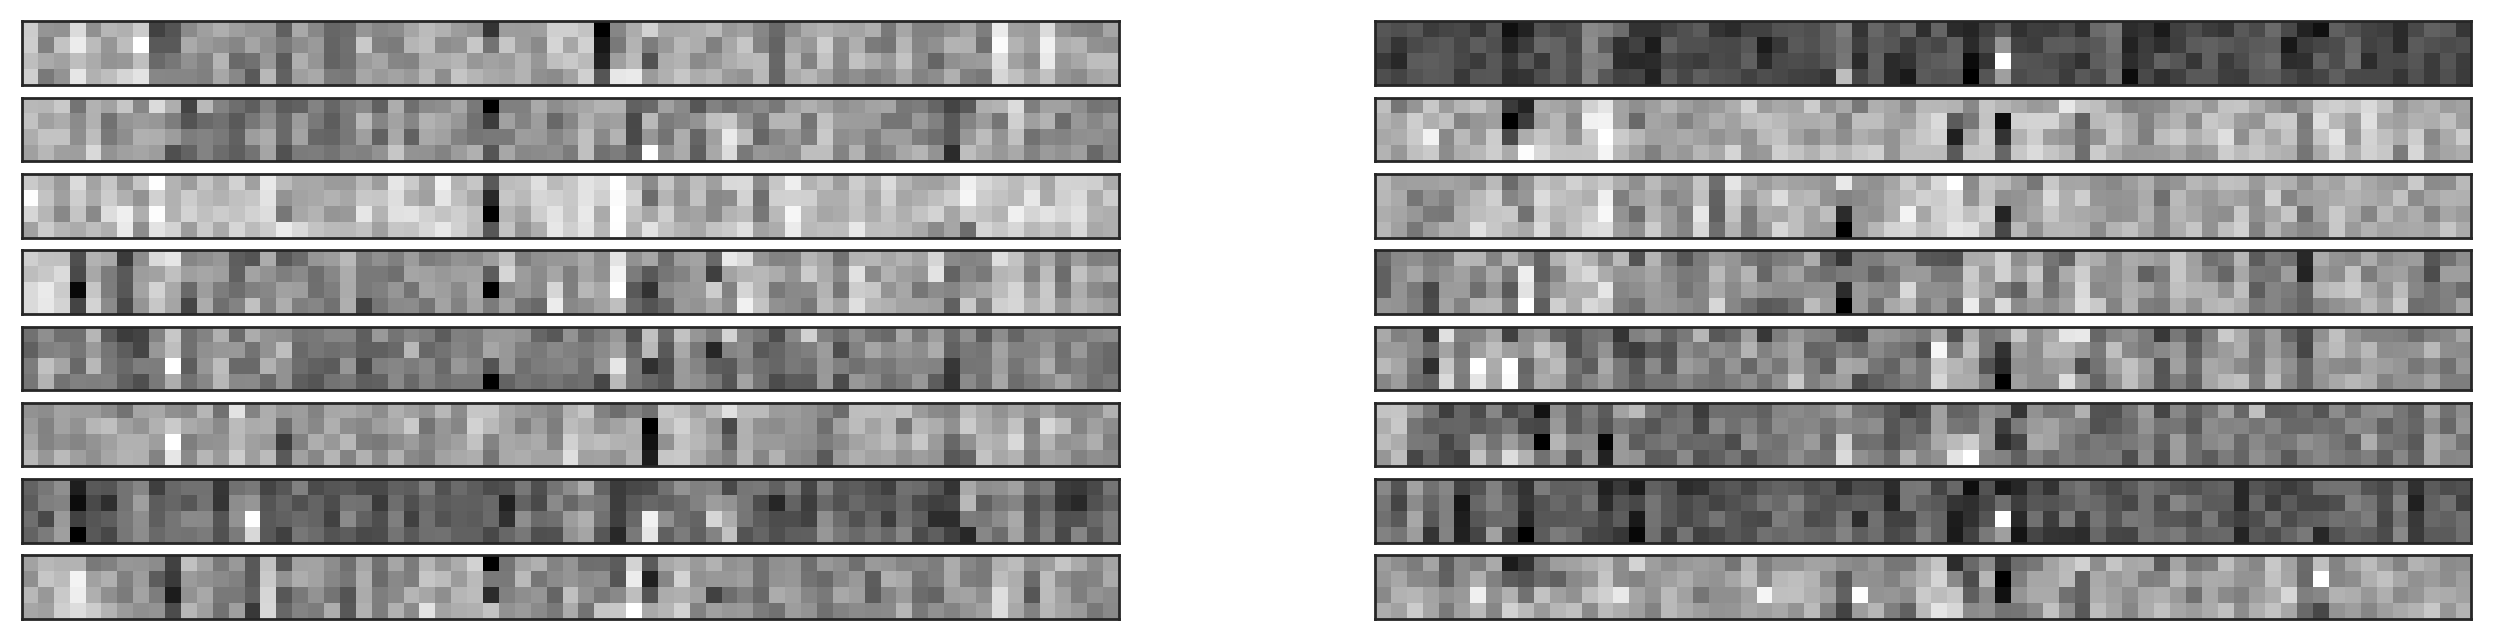

In [ ]:
from matplotlib import pyplot
from matplotlib.pyplot import figure
figure(num=None, figsize=(20,10), dpi=160, facecolor='w', edgecolor='k')
# plot first 16 filters
n_filters, ix = 16, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, i]
    # plot each channel separately

    # specify subplot and turn of axis
    ax = pyplot.subplot(n_filters, 2, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    pyplot.imshow(f[:, :], cmap='gray')
    ix += 1
# show the figure
pyplot.show()

### Visualize Feature Map

In [ ]:
# Take out a part of the model to fetch the feature mapping
# We are taking the feature mapping from the first Convolutional layer
feature_mapping = Model(inputs=model.inputs, outputs=model.layers[0].output)

prediction_valid = model.predict(X_valid_scaled).squeeze()

top_true_positives = np.where(
    np.logical_and(prediction_valid > 0.78, y_valid == 1))[0]

top_true_negatives = np.where(
    np.logical_and(prediction_valid < 1e-10, y_valid == 0))[0]

In [ ]:
from matplotlib import pyplot
from matplotlib.pyplot import figure
figure(num=None, figsize=(4, 4), dpi=160, facecolor='w')


def plot_feature_maps(top_predictions):

    n_feature_maps, ix = 10, 1

    for i in range(n_feature_maps):

        samplex = X_valid_scaled[top_predictions[i], :, :]
        samplex = samplex.reshape((1, samplex.shape[0], samplex.shape[1]))

        feature_map = feature_mapping.predict(samplex).squeeze()

        ax = pyplot.subplot(np.round(n_feature_maps / 2), 2, ix)
        ax.set_xticks([])
        ax.set_yticks([])

        # plot filter channel in grayscale
        pyplot.imshow(np.transpose(1 - (feature_map - feature_map.min()) /
                                   (feature_map.max() - feature_map.min())),
                      cmap='viridis')
        ix += 1

    # show the figure
    pyplot.show()

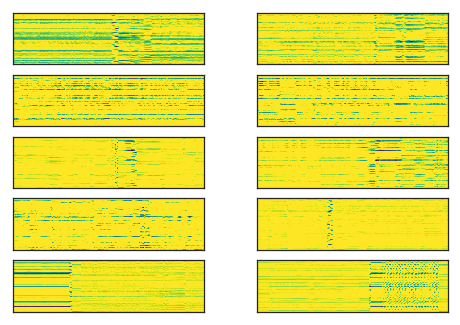

In [ ]:
plot_feature_maps(top_true_positives)

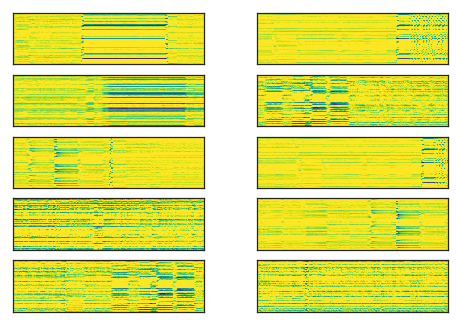

In [ ]:
plot_feature_maps(top_true_negatives)

# Multiple Pooling in parallel: Maximum statistic + Range statistic pooling

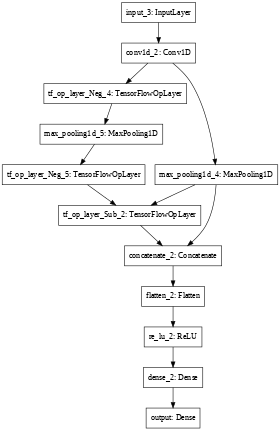

In [ ]:
x = Input(shape=(TIMESTEPS, N_FEATURES))

conv = Conv1D(filters=16, 
              kernel_size=4,
              activation='linear', 
              padding='valid')(x)

# left operations
max_statistic = MaxPool1D(pool_size=4, 
                          padding='valid')(conv)

# right operations
# 1. negative of feature map
range_statistic = tf.math.negative(conv)
# 2. apply maxpool to get the min statistics
range_statistic = MaxPool1D(pool_size=4, 
                      padding='valid')(range_statistic)
# 3. negative of negative in step (1) to revert to original
range_statistic = tf.math.negative(range_statistic)
# 4. subtract with max_statistic to get the 
# range statistic max(x) - min(x)
range_statistic = tf.math.subtract(max_statistic, 
                             range_statistic)

# Concatenate the pool
concatted = tf.keras.layers.Concatenate()([max_statistic, 
                                           range_statistic])

features = Flatten()(concatted)

features = ReLU()(features)

# 128 nodes for lookback = 20 or 40.
dense = Dense(units=256, 
              activation='relu')(features) 

predictions = Dense(units=1, 
                    activation='sigmoid', 
                    name='output')(dense)

model = Model(inputs=x,
              outputs=predictions)

# Plot the network structure
tf.keras.utils.plot_model(model, 
                          show_shapes=False, 
                          dpi=80)


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  pm.F1Score(),
                  pm.FalsePositiveRate()
              ])
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=150,
                    validation_data=(X_valid_scaled, 
                                     y_valid),
                    verbose=1).history

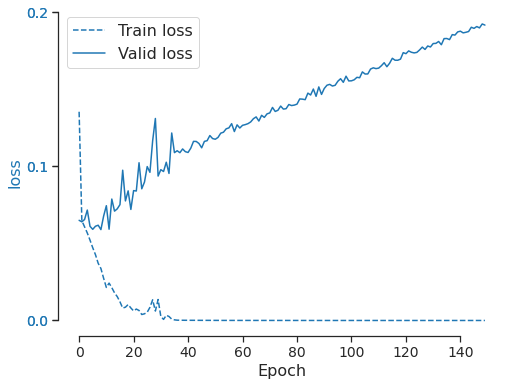

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
fig.savefig('cnn_baseline_conv_linear_pooling_relu_range_stat_240_loss.pdf', bbox_inches='tight')

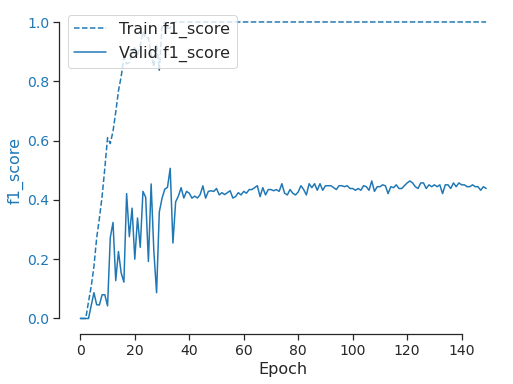

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('cnn_baseline_conv_linear_pooling_relu_range_stat_240_f1_score.pdf', bbox_inches='tight')

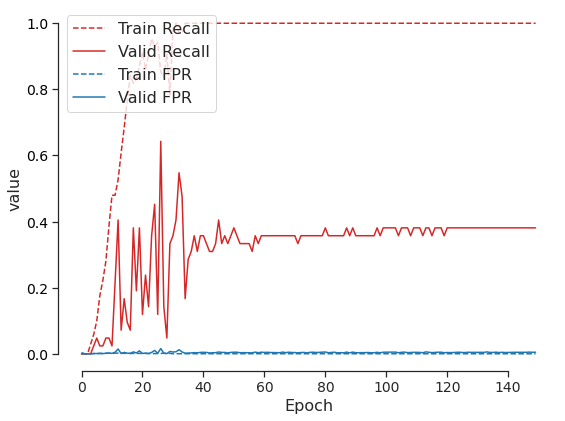

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
fig.savefig('cnn_baseline_conv_linear_pooling_relu_range_stat_240_recall_fpr.pdf', bbox_inches='tight')